In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import keras.layers as layers
import keras
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/bs-cse-iitb/FML_Project/main/diabetes_full.csv")
data = data.drop_duplicates()

In [3]:
data['Diabetes_012'] = np.where(data['Diabetes_012'] == 0.0,0.0,1.0)
data.Diabetes_012.value_counts()
data.rename(columns={'Diabetes_012':'Diabetes_binary'},inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [4]:
# sns.barplot(data.Diabetes_binary.value_counts().index,data.Diabetes_binary.value_counts().values)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


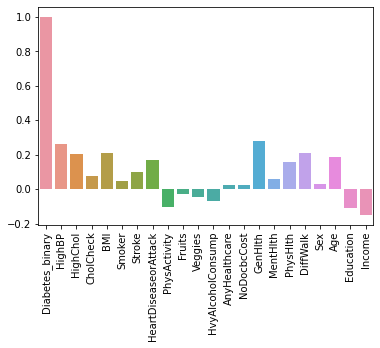

In [5]:
corr = data.corr()
graph = sns.barplot(corr.Diabetes_binary.index,corr.Diabetes_binary.values)
graph.set_xticklabels(labels=corr.Diabetes_binary.index, rotation=90)

plt.show()

In [6]:
variables_to_drop = ['Fruits','Veggies','AnyHealthcare','NoDocbcCost','Sex']

data.drop(variables_to_drop,axis=1,inplace=True)


In [7]:
y = data.Diabetes_binary
X = data.drop('Diabetes_binary',axis = 1)

In [8]:
# # continous_var_list = ['BMI','MentHlth','PhysHlth']
# continous_var_list = []

# categorical_var  = []
# for var in X.columns:
#   if var not in continous_var_list:
#     categorical_var.append(var)
# print(categorical_var)
# X = pd.get_dummies(X,columns=categorical_var)

In [9]:
X = np.asarray(X)
y = np.asarray(y)

In [10]:
from imblearn.under_sampling import NearMiss,CondensedNearestNeighbour,TomekLinks,EditedNearestNeighbours
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# nm = TomekLinks() # accuracy: 0.8358 - 10min
# nm = EditedNearestNeighbours(n_neighbors=3) # accuracy: 0.8560 - 13min (n=3)
nm = NearMiss(version = 1 , n_neighbors = 20) #accuracy: 0.8626 - 5min (n=20) // 0.853439 when 1-Hot done after undersampling
# nm = NearMiss(version = 1 , n_neighbors = 10) #accuracy: 0.8559 - 4min (n=10) // 0.849852 when 1-Hot done after undersampling
# # nm = NearMiss(version = 1 , n_neighbors = 5) #0.844755 - 3min (n=5)

# from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# nm = SMOTE() # accuracy: 0.8314
# nm = ADASYN() # accuracy: 0.8213

x_sm,y_sm= nm.fit_resample(X,y)
X,y=x_sm,y_sm 

print(X.shape)

(79452, 16)


In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,train_size=0.8)

In [12]:
from sklearn.preprocessing import MaxAbsScaler,StandardScaler,MinMaxScaler,RobustScaler,PowerTransformer,QuantileTransformer

scaler = RobustScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  

# mixmax - accuracy: 0.8537
# maxabs - accuracy: 0.8499
# standard - accuracy: 0.8634
# robust - accuracy: 0.8658
# power - accuracy: 0.8643
# quantile - accuracy: 0.8520

In [13]:
X_train.shape

(63561, 16)

In [20]:
from sklearn.metrics import accuracy_score

# Grid Search NN
max_accuracy = 0.0
best_model = None

for i in {0.001}:
  for j in {64}:
    for k in {30}:
      
      model = Sequential()
      model.add(layers.InputLayer((X_train.shape[1],)))
      model.add(Dense(32,activation='relu'))
      model.add(Dense(64,activation='relu'))
      model.add(Dense(1,activation='sigmoid'))

      optimizer = keras.optimizers.Adam(learning_rate = i)
      model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
      history = model.fit(X_train,y_train,batch_size=j,epochs=k,validation_split=0.2)
      p_pred = model.predict(X_test)
      p_pred = p_pred.flatten()

      # extract the predicted class labels
      y_pred = np.where(p_pred > 0.5, 1, 0)
      
      current_accuracy = accuracy_score(y_test,y_pred)
      if(current_accuracy > max_accuracy):
        best_model = model
        max_accuracy = current_accuracy

y_pred = best_model.predict(X_train)
print("Neural Network Max Accuracy : ",max_accuracy)

neuralNetworkModel = best_model

y_val = neuralNetworkModel.predict(X_train)

# extract the predicted class labels
y_val = np.where(y_val > 0.5, 1, 0)
y_pred = neuralNetworkModel.predict(X_test)

y_pred = y_pred.flatten()

# extract the predicted class labels
y_pred = np.where(p_pred > 0.5, 1, 0)

Epoch 1/30
795/795 [==============================] - 6s 6ms/step - loss: 0.3562 - accuracy: 0.8404 - val_loss: 0.3356 - val_accuracy: 0.8531
Epoch 2/30
795/795 [==============================] - 2s 2ms/step - loss: 0.3304 - accuracy: 0.8566 - val_loss: 0.3280 - val_accuracy: 0.8592
Epoch 3/30
795/795 [==============================] - 2s 2ms/step - loss: 0.3204 - accuracy: 0.8616 - val_loss: 0.3175 - val_accuracy: 0.8641
Epoch 4/30
795/795 [==============================] - 2s 2ms/step - loss: 0.3136 - accuracy: 0.8657 - val_loss: 0.3152 - val_accuracy: 0.8656
Epoch 5/30
795/795 [==============================] - 2s 2ms/step - loss: 0.3095 - accuracy: 0.8678 - val_loss: 0.3091 - val_accuracy: 0.8673
Epoch 6/30
795/795 [==============================] - 2s 2ms/step - loss: 0.3051 - accuracy: 0.8701 - val_loss: 0.3076 - val_accuracy: 0.8678
Epoch 7/30
795/795 [==============================] - 3s 4ms/step - loss: 0.3020 - accuracy: 0.8710 - val_loss: 0.3055 - val_accuracy: 0.8678
Epoch 

In [21]:
from sklearn.metrics import classification_report

print("~~~  TRAIN ACCURACY  ~~~")
print(classification_report(y_train, y_val, digits=6))

print("~~~  TEST ACCURACY  ~~~")
print(classification_report(y_test, y_pred, digits=6))

~~~  TRAIN ACCURACY  ~~~
              precision    recall  f1-score   support

         0.0   0.820580  0.966390  0.887536     31836
         1.0   0.958954  0.787959  0.865087     31725

    accuracy                       0.877330     63561
   macro avg   0.889767  0.877175  0.876312     63561
weighted avg   0.889646  0.877330  0.876331     63561

~~~  TEST ACCURACY  ~~~
              precision    recall  f1-score   support

         0.0   0.811698  0.962104  0.880524      7890
         1.0   0.954274  0.779903  0.858322      8001

    accuracy                       0.870367     15891
   macro avg   0.882986  0.871003  0.869423     15891
weighted avg   0.883484  0.870367  0.869346     15891



In [15]:
# history = model.fit(X_train,y_train,batch_size=256,epochs=20,validation_split=0.2) # accuracy: 0.8680
# history = model.fit(X_train,y_train,batch_size=256,epochs=50,validation_split=0.2) # accuracy: 0.8682

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

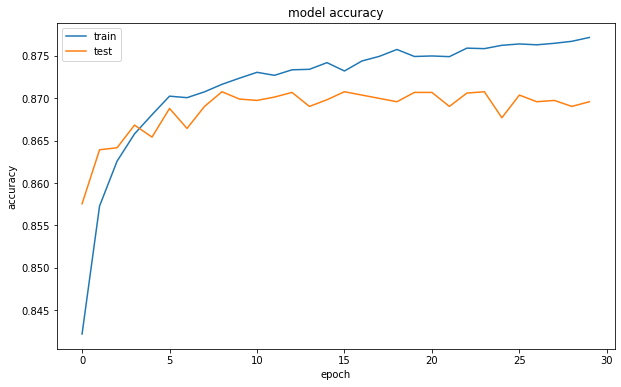

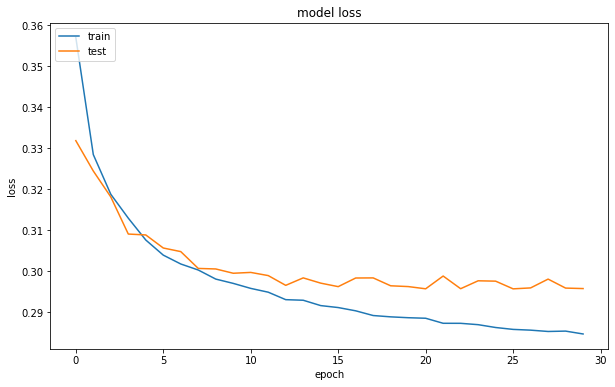

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
from google.colab import files
plt.savefig("nn1.pdf", bbox_inches = 'tight')
files.download("nn1.pdf")

fig = plt.figure(figsize=(10, 6))
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

from google.colab import files
plt.savefig("nn2.pdf", bbox_inches = 'tight')
files.download("nn2.pdf")

In [17]:
model.evaluate(X_test,y_test)

497/497 [==============================] - 1s 1ms/step - loss: 0.2983 - accuracy: 0.8721


[0.2982980012893677, 0.8720659613609314]